In [2]:
# dependencies needed
!pip install pandas
!pip install pgmpy
!pip install torch


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
import networkx as nx
from pgmpy.factors.discrete import TabularCPD
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import pgmpy

print(pgmpy.__version__)
print(pgmpy.__file__)


0.1.26
/Users/laithyaser/COMP5023 AI-CW/.venv/lib/python3.10/site-packages/pgmpy/__init__.py


In [84]:
import sys
print(sys.executable)


/usr/local/bin/python3.12


In [4]:
# path to the file
df = pd.read_csv("heart_attack_prediction_indonesia.csv")

In [5]:
print("First 5 records:\n", df.head())
df.info()

First 5 records:
    age  gender region income_level  hypertension  diabetes  cholesterol_level  \
0   60    Male  Rural       Middle             0         1                211   
1   53  Female  Urban          Low             0         0                208   
2   62  Female  Urban          Low             0         0                231   
3   73    Male  Urban          Low             1         0                202   
4   52    Male  Urban       Middle             1         0                232   

   obesity  waist_circumference  family_history  ... blood_pressure_diastolic  \
0        0                   83               0  ...                       62   
1        0                  106               1  ...                       76   
2        1                  112               1  ...                       74   
3        0                   82               1  ...                       65   
4        0                   89               0  ...                       75   

  fastin

In [108]:
# Calculating the probability a patient had a heart attack P(Heart Attack) and  the probability a patient has diabetes P(Diabetes)
# "Independently!!"

# P(Heart Attack)
prob_heart_attack = len(df[df["heart_attack"] == 1])/len(df)
# P(Diabetes)
prob_diabetes = len(df[df["diabetes"] == 1])/len(df)

print("P(Heart Attack): ", prob_heart_attack)
print("P(Diabetes): ", prob_diabetes)

P(Heart Attack):  0.4010040731268353
P(Diabetes):  0.19980423731489375


In [69]:
# Calculating the join probability P(Heart Attack & Diabetes)
joint_probability = len(df[(df["heart_attack"] == 1) & (df["diabetes"] == 1)]) / len(df)
print( "Output: ")
print("P(Heart Attack): ", prob_heart_attack)
print("P(Diabetes): ", prob_diabetes)
print("Joint Probability P(Heart Attack & Diabetes): ", joint_probability)

Output: 
P(Heart Attack):  0.4010040731268353
P(Diabetes):  0.19980423731489375
Joint Probability P(Heart Attack & Diabetes):  0.11824066180417417


In [6]:
"""Let
   N1 = Has Hypertension == 1
   N2 = High Cholesterol > 200
   NQ = Had a Heart Attack
   NQ1 = Has a family history == 1
   NQ2 =  Has Obesity == 1
   """

df['hypertension_'] = df['hypertension'].apply(lambda x: 'Yes' if x == 1 else 'No')
df['cholesterol_level_'] = df['cholesterol_level'].apply(lambda x: 'High' if x > 200 else 'Normal')
df['family_history_'] = df['family_history'].apply(lambda x: 'Yes' if x == 1 else 'No')
df['obesity_'] = df['obesity'].apply(lambda x: 'Yes' if x == 1 else 'No')
df['heart_attack_'] = df['heart_attack'].apply(lambda x: 'Yes' if x == 1 else 'No')

In [7]:
model = BayesianNetwork([
    ('hypertension_',  'heart_attack_'),
    ('cholesterol_level_',   'heart_attack_'),
    ('family_history_','heart_attack_'),
    ('obesity_',       'heart_attack_')
])

In [117]:
model.fit(df, estimator=MaximumLikelihoodEstimator)
model.check_model()

True

In [118]:
infer = VariableElimination(model)

In [128]:
#  Query 1:
#  Heart_attack given that 'hypertension' is 'Yes'.
prob_query1 = infer.query(variables=['heart_attack_'],evidence={'hypertension_': "Yes"}
)
print("Query 1: P(heart_attack | hypertension =Yes)")
print(prob_query1)


Query 1: P(heart_attack | hypertension =Yes)
+--------------------+----------------------+
| heart_attack_      |   phi(heart_attack_) |
+====================+======================+
| heart_attack_(No)  |               0.3967 |
+--------------------+----------------------+
| heart_attack_(Yes) |               0.6033 |
+--------------------+----------------------+


In [129]:
# Query 2:
# P(heart_attack | hypertension = 'Yes', cholesterol_level = 'Normal')
prob_query2 = infer.query(variables=['heart_attack_'],evidence={'hypertension_': 'Yes', 'cholesterol_level_': 'Normal'}
)
print("\nQuery 2: P(heart_attack | hypertension =Yes, cholesterol_level=Normal)")
print(prob_query2)


Query 2: P(heart_attack | hypertension =Yes, cholesterol_level=Normal)
+--------------------+----------------------+
| heart_attack_      |   phi(heart_attack_) |
+====================+======================+
| heart_attack_(No)  |               0.4227 |
+--------------------+----------------------+
| heart_attack_(Yes) |               0.5773 |
+--------------------+----------------------+


In [122]:
# Query 3:
prob_query3 = infer.query(variables=['family_history_', 'obesity_'],evidence={'hypertension_': 'No', 'cholesterol_level_': 'High'}
)
print("\nQuery 3: Joint distribution of (family_history, obesity) given (hypertension =No, cholesterol_level=High)")
print(prob_query3)
p_fam_obs = prob_query3.get_value(family_history_='Yes', obesity_='Yes')
print("\nP(family_history =Yes, obesity =Yes | hypertension =No, cholesterol_level=High) =", p_fam_obs)


Query 3: Joint distribution of (family_history, obesity) given (hypertension =No, cholesterol_level=High)
+----------------------+---------------+---------------------------------+
| family_history_      | obesity_      |   phi(family_history_,obesity_) |
+======================+===============+=================================+
| family_history_(No)  | obesity_(No)  |                          0.5249 |
+----------------------+---------------+---------------------------------+
| family_history_(No)  | obesity_(Yes) |                          0.1749 |
+----------------------+---------------+---------------------------------+
| family_history_(Yes) | obesity_(No)  |                          0.2252 |
+----------------------+---------------+---------------------------------+
| family_history_(Yes) | obesity_(Yes) |                          0.0750 |
+----------------------+---------------+---------------------------------+

P(family_history =Yes, obesity =Yes | hypertension =No, cholesterol

In [130]:
# Query 3:
# P(family_history | hypertension = 'No', cholesterol_level = 'High')
prob_query3a = infer.query(
    variables=['family_history_'],
    evidence={'hypertension_': 'No', 'cholesterol_level_': 'High'}
)
print("Query 3a: P(family_history | hypertension = 'No', cholesterol_level_ = 'High')")
print(prob_query3a)
p_fam = prob_query3a.get_value(family_history_='Yes')
print("P(family_history = 'Yes' | hypertension = 'No', cholesterol_level = 'High') =", p_fam)

Query 3a: P(family_history | hypertension = 'No', cholesterol_level_ = 'High')
+----------------------+------------------------+
| family_history_      |   phi(family_history_) |
+======================+========================+
| family_history_(No)  |                 0.6998 |
+----------------------+------------------------+
| family_history_(Yes) |                 0.3002 |
+----------------------+------------------------+
P(family_history = 'Yes' | hypertension = 'No', cholesterol_level = 'High') = 0.3002178649237473


In [131]:
# Query 3:
# P(obesity | hypertension = 'No', cholesterol_level = 'High')
prob_query3b = infer.query(
    variables=['obesity_'],
    evidence={'hypertension_': 'No', 'cholesterol_level_': 'High'}
)
print("\nQuery 3b: P(obesity | hypertension = 'No', cholesterol_level = 'High')")
print(prob_query3b)
p_obs = prob_query3b.get_value(obesity_='Yes')
print("P(obesity = 'Yes' | hypertension_ = 'No', cholesterol_level_ = 'High') =", p_obs)



Query 3b: P(obesity | hypertension = 'No', cholesterol_level = 'High')
+---------------+-----------------+
| obesity_      |   phi(obesity_) |
+===============+=================+
| obesity_(No)  |          0.7501 |
+---------------+-----------------+
| obesity_(Yes) |          0.2499 |
+---------------+-----------------+
P(obesity = 'Yes' | hypertension_ = 'No', cholesterol_level_ = 'High') = 0.24990053992611538


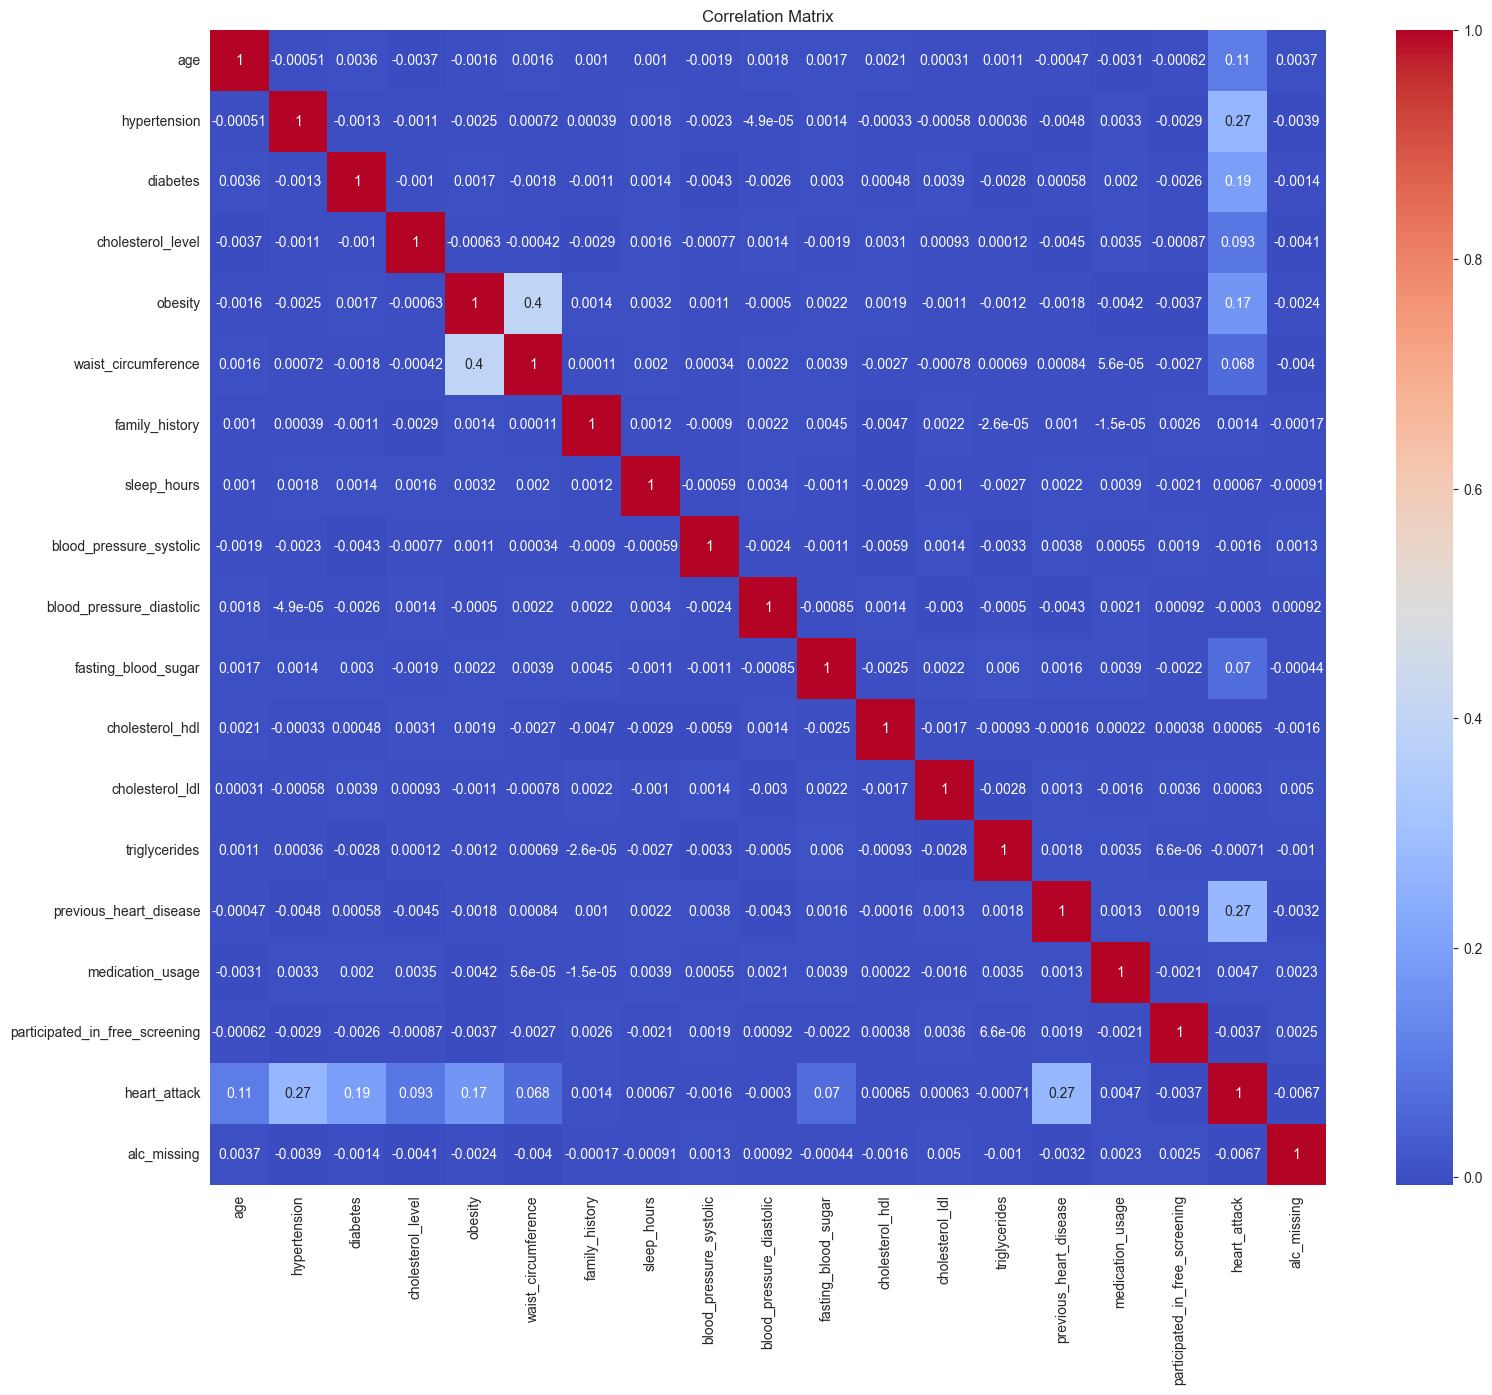

In [12]:
df['alc_missing'] = df['alcohol_consumption'].isnull()
grouped = df.groupby('alc_missing').agg({
    'age': ['mean','median'],
    'income_level': lambda x: x.mode()[0],
    'hypertension': 'mean',
    'diabetes': 'mean',
    'cholesterol_level': 'mean',
    'heart_attack': 'mean'
})

corr = df.copy()
corr['alc_missing'] = corr['alc_missing'].astype(int)
numeric_cols = corr.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(18, 15))
sns.heatmap(corr[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


In [49]:
model = BayesianNetwork([
    ('Age', 'Hypertension'),
    ('Age', 'Diabetes'),
    ('Age', 'Cholesterol'),
    ('Age', 'Obesity'),
    ('Gender', 'Cholesterol'),
    ('Family_history', 'Heart_attack'),
    ('Hypertension', 'Heart_attack'),
    ('Diabetes', 'Heart_attack'),
    ('Cholesterol', 'Heart_attack'),
    ('Obesity', 'Heart_attack'),
    ('Smoking_status', 'Heart_attack'),
    ('EKG_results', 'Heart_attack'),
    ('Smoking_status', 'EKG_results')
])


In [29]:
# Age
cpd_age = TabularCPD(
    variable='Age', variable_card=3,
    values=[[0.4], [0.35], [0.25]],
    state_names={'Age': ['Young', 'Middle', 'Old']}
)

print("Age CPT: ")
print(cpd_age)

Age CPT: 
+-------------+------+
| Age(Young)  | 0.4  |
+-------------+------+
| Age(Middle) | 0.35 |
+-------------+------+
| Age(Old)    | 0.25 |
+-------------+------+


In [28]:
# Gender
cpd_gender = TabularCPD(
    variable='Gender', variable_card=2,
    values=[[0.5], [0.5]],
    state_names={'Gender': ['Male', 'Female']}
)

print("Gender CPT: ")
print(cpd_gender)

Gender CPT: 
+----------------+-----+
| Gender(Male)   | 0.5 |
+----------------+-----+
| Gender(Female) | 0.5 |
+----------------+-----+


In [30]:
# Family History
cpd_family_history = TabularCPD(
    variable='Family_history', variable_card=2,
    values=[[0.7], [0.3]],
    state_names={'Family_history': ['No', 'Yes']}
)
print("Family_history CPT: ")
print(cpd_family_history)

Family_history CPT: 
+---------------------+-----+
| Family_history(No)  | 0.7 |
+---------------------+-----+
| Family_history(Yes) | 0.3 |
+---------------------+-----+


In [31]:
# Smoking Status
cpd_smoking = TabularCPD(
    variable='Smoking_status', variable_card=3,
    values=[[0.5], [0.3], [0.2]],
    state_names={'Smoking_status': ['Never', 'Ex-smoker', 'Current']}
)
print("Smoking_status CPT: ")
print(cpd_smoking)

Smoking_status CPT: 
+---------------------------+-----+
| Smoking_status(Never)     | 0.5 |
+---------------------------+-----+
| Smoking_status(Ex-smoker) | 0.3 |
+---------------------------+-----+
| Smoking_status(Current)   | 0.2 |
+---------------------------+-----+


In [122]:
# Hypertension depends on age
cpd_hypertension = TabularCPD(
    variable='Hypertension', variable_card=2,
    values=[[0.9, 0.7, 0.4],   # P(Hypertension='No' | Age)
            [0.1, 0.3, 0.6]], # P(Hypertension='Yes'| Age)
    evidence=['Age'], evidence_card=[3],
    state_names={
        'Hypertension': ['No', 'Yes'],
        'Age': ['Young', 'Middle', 'Old']
    }
)
print("Hypertension CPT: ")
print(cpd_hypertension)

Hypertension CPT: 
+-------------------+------------+-------------+----------+
| Age               | Age(Young) | Age(Middle) | Age(Old) |
+-------------------+------------+-------------+----------+
| Hypertension(No)  | 0.9        | 0.7         | 0.4      |
+-------------------+------------+-------------+----------+
| Hypertension(Yes) | 0.1        | 0.3         | 0.6      |
+-------------------+------------+-------------+----------+


In [33]:
# Diabetes depends on Age.
cpd_diabetes = TabularCPD(
    variable='Diabetes', variable_card=2,
    values=[[0.95, 0.85, 0.70],
            [0.05, 0.15, 0.30]],
    evidence=['Age'], evidence_card=[3],
    state_names={
        'Diabetes': ['No', 'Yes'],
        'Age': ['Young', 'Middle', 'Old']
    }
)
print("Diabetes CPT: ")
print(cpd_diabetes)

Diabetes CPT: 
+---------------+------------+-------------+----------+
| Age           | Age(Young) | Age(Middle) | Age(Old) |
+---------------+------------+-------------+----------+
| Diabetes(No)  | 0.95       | 0.85        | 0.7      |
+---------------+------------+-------------+----------+
| Diabetes(Yes) | 0.05       | 0.15        | 0.3      |
+---------------+------------+-------------+----------+


In [34]:
# Obesity depends on Age.
cpd_obesity = TabularCPD(
    variable='Obesity', variable_card=2,
    values=[[0.8, 0.7, 0.6],
            [0.2, 0.3, 0.4]],
    evidence=['Age'], evidence_card=[3],
    state_names={
        'Obesity': ['No', 'Yes'],
        'Age': ['Young', 'Middle', 'Old']
    }
)
print("Obesity CPT: ")
print(cpd_obesity)

Obesity CPT: 
+--------------+------------+-------------+----------+
| Age          | Age(Young) | Age(Middle) | Age(Old) |
+--------------+------------+-------------+----------+
| Obesity(No)  | 0.8        | 0.7         | 0.6      |
+--------------+------------+-------------+----------+
| Obesity(Yes) | 0.2        | 0.3         | 0.4      |
+--------------+------------+-------------+----------+


In [74]:
# Cholesterol depends on Age and Gender.
cpd_cholesterol = TabularCPD(
    variable='Cholesterol', variable_card=3,
    # The order of columns is (Age=Young,Gender=Male), (Age=Young,Gender=Female),
    # (Age=Middle,Gender=Male), (Age=Middle,Gender=Female),
    # (Age=Old,Gender=Male), (Age=Old,Gender=Female)
    values=[
        [0.70, 0.75, 0.50, 0.55, 0.40, 0.45],  # 'Normal'
        [0.20, 0.15, 0.30, 0.30, 0.30, 0.30],  # 'Borderline'
        [0.10, 0.10, 0.20, 0.15, 0.30, 0.25]   # 'High'
    ],
    evidence=['Age', 'Gender'], evidence_card=[3, 2],
    state_names={
        'Cholesterol': ['Normal', 'Borderline', 'High'],
        'Age': ['Young', 'Middle', 'Old'],
        'Gender': ['Male', 'Female']
    }
)
print("Cholesterol CPT: ")
print(cpd_cholesterol)

df_cholesterol = pd.DataFrame([
    ['Young', 'Male',   0.70, 0.20, 0.10],
    ['Young', 'Female', 0.75, 0.15, 0.10],
    ['Middle','Male',   0.50, 0.30, 0.20],
    ['Middle','Female', 0.55, 0.30, 0.15],
    ['Old',   'Male',   0.40, 0.30, 0.30],
    ['Old',   'Female', 0.45, 0.30, 0.25],
],
    columns=['Age','Gender','Normal','Borderline','High']
)

print("Cholesterol CPT:")
print(df_cholesterol)



Cholesterol CPT: 
+-------------------------+-----+--------------+----------------+
| Age                     | ... | Age(Old)     | Age(Old)       |
+-------------------------+-----+--------------+----------------+
| Gender                  | ... | Gender(Male) | Gender(Female) |
+-------------------------+-----+--------------+----------------+
| Cholesterol(Normal)     | ... | 0.4          | 0.45           |
+-------------------------+-----+--------------+----------------+
| Cholesterol(Borderline) | ... | 0.3          | 0.3            |
+-------------------------+-----+--------------+----------------+
| Cholesterol(High)       | ... | 0.3          | 0.25           |
+-------------------------+-----+--------------+----------------+
Cholesterol CPT:
      Age  Gender  Normal  Borderline  High
0   Young    Male    0.70        0.20  0.10
1   Young  Female    0.75        0.15  0.10
2  Middle    Male    0.50        0.30  0.20
3  Middle  Female    0.55        0.30  0.15
4     Old    Male  

In [71]:
# EKG_results depends on Smoking_status.
cpd_EKG = TabularCPD(
    variable='EKG_results', variable_card=2,
    values=[
        [0.9, 0.8, 0.6],  # P(EKG='Normal' | Smoking_status)
        [0.1, 0.2, 0.4]   # P(EKG='Abnormal'| Smoking_status)
    ],
    evidence=['Smoking_status'], evidence_card=[3],
    state_names={
        'EKG_results': ['Normal', 'Abnormal'],
        'Smoking_status': ['Never', 'Ex-smoker', 'Current']
    }
)
# print("EKG_results CPT: ")
# print(cpd_EKG)

# more presentable result than the library
print("EKG_results CPT :")
print("+--------------------------+------------------------+---------------------------+-------------------------+")
print("|      Smoking_Status      |  Smoking_status(Never) | Smoking_status(Ex-smoker) | Smoking_status(Current) |")
print("+--------------------------+------------------------+---------------------------+-------------------------+")
print("|   EKG_results(Normal)    |          0.90          |            0.80           |            0.60         |")
print("+--------------------------+------------------------+---------------------------+-------------------------+")
print("|  EKG_results(Abnormal)   |          0.10          |            0.20           |            0.40         |")
print("+--------------------------+------------------------+---------------------------+-------------------------+")


EKG_results CPT :
+--------------------------+------------------------+---------------------------+-------------------------+
|      Smoking_Status      |  Smoking_status(Never) | Smoking_status(Ex-smoker) | Smoking_status(Current) |
+--------------------------+------------------------+---------------------------+-------------------------+
|   EKG_results(Normal)    |          0.90          |            0.80           |            0.60         |
+--------------------------+------------------------+---------------------------+-------------------------+
|  EKG_results(Abnormal)   |          0.10          |            0.20           |            0.40         |
+--------------------------+------------------------+---------------------------+-------------------------+


In [43]:
# Heart_attack depends on 7 parents:
# Family_history, Hypertension, Diabetes, Cholesterol, Obesity, Smoking_status, EKG_results
states_family_history = ['No', 'Yes']
states_hypertension   = ['No', 'Yes']
states_diabetes       = ['No', 'Yes']
states_cholesterol    = ['Normal', 'Borderline', 'High']
states_obesity        = ['No', 'Yes']
states_smoking        = ['Never', 'Ex-smoker', 'Current']
states_EKG            = ['Normal', 'Abnormal']

parent_combinations = list(itertools.product(
    states_family_history, states_hypertension, states_diabetes,
    states_cholesterol, states_obesity, states_smoking, states_EKG
))

def compute_heart_attack_risk(fam, hype, diab, chol, obes, smok, ekg):
    risk = 0.05
    if fam == 'Yes': risk += 0.1
    if hype == 'Yes': risk += 0.1
    if diab == 'Yes': risk += 0.1
    if obes == 'Yes': risk += 0.1
    if chol == 'Borderline': risk += 0.05
    elif chol == 'High': risk += 0.1
    if smok == 'Ex-smoker': risk += 0.05
    elif smok == 'Current': risk += 0.1
    if ekg == 'Abnormal': risk += 0.15
    return min(risk, 0.99)

heart_attack_yes_probs = [compute_heart_attack_risk(*combo) for combo in parent_combinations]
heart_attack_no_probs = [1 - p for p in heart_attack_yes_probs]

cpd_heart_attack = TabularCPD(
    variable='Heart_attack', variable_card=2,
    values=[heart_attack_no_probs, heart_attack_yes_probs],
    evidence=[
        'Family_history', 'Hypertension', 'Diabetes',
        'Cholesterol', 'Obesity', 'Smoking_status', 'EKG_results'
    ],
    evidence_card=[2,2,2,3,2,3,2],
    state_names={
        'Heart_attack': ['No', 'Yes'],
        'Family_history': states_family_history,
        'Hypertension': states_hypertension,
        'Diabetes': ['No', 'Yes'],
        'Cholesterol': ['Normal', 'Borderline', 'High'],
        'Obesity': ['No', 'Yes'],
        'Smoking_status': ['Never', 'Ex-smoker', 'Current'],
        'EKG_results': ['Normal', 'Abnormal']
    }
)
print("Heart Attack CPT: ")
print(cpd_heart_attack)

Heart Attack CPT: 
+-------------------+-----+-------------------------+
| Family_history    | ... | Family_history(Yes)     |
+-------------------+-----+-------------------------+
| Hypertension      | ... | Hypertension(Yes)       |
+-------------------+-----+-------------------------+
| Diabetes          | ... | Diabetes(Yes)           |
+-------------------+-----+-------------------------+
| Cholesterol       | ... | Cholesterol(High)       |
+-------------------+-----+-------------------------+
| Obesity           | ... | Obesity(Yes)            |
+-------------------+-----+-------------------------+
| Smoking_status    | ... | Smoking_status(Current) |
+-------------------+-----+-------------------------+
| EKG_results       | ... | EKG_results(Abnormal)   |
+-------------------+-----+-------------------------+
| Heart_attack(No)  | ... | 0.20000000000000007     |
+-------------------+-----+-------------------------+
| Heart_attack(Yes) | ... | 0.7999999999999999      |
+--------

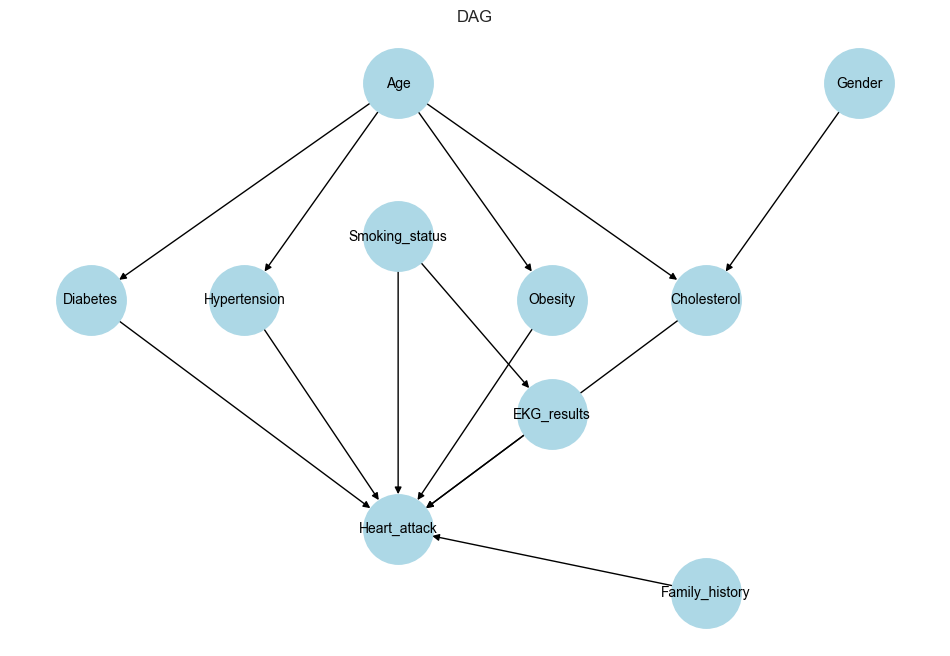

In [80]:
model.add_cpds(
    cpd_age, cpd_gender, cpd_family_history, cpd_smoking,
    cpd_hypertension, cpd_diabetes, cpd_obesity, cpd_cholesterol,
    cpd_EKG, cpd_heart_attack
)

model.check_model()
G = nx.DiGraph()
G.add_nodes_from(model.nodes())
G.add_edges_from(model.edges())

plt.figure(figsize=(12, 8))
pos = {
    'Age': (0, 2),
    'Gender': (3, 2),
    'Family_history': (2, -2),
    'Smoking_status': (0, 0.8),
    'Hypertension': (-1, 0.3),
    'Diabetes': (-2, 0.3),
    'Obesity': (1, 0.3),
    'Cholesterol': (2, 0.3),
    'EKG_results': (1, -0.6),
    'Heart_attack': (0, -1.5)
}

nx.draw_networkx(
    G, pos,
    with_labels=True,
    node_size=2500,
    node_color="lightblue",
    font_size=10,
    arrows=True
)

plt.title("DAG")
plt.axis('off')
plt.show()

In [8]:
### Sampling Methods
from pgmpy.sampling import BayesianModelSampling

In [9]:
df['hypertension_'] = df['hypertension'].apply(lambda x: 'Yes' if x == 1 else 'No')
df['cholesterol_level_'] = df['cholesterol_level'].apply(lambda x: 'High' if x > 200 else 'Normal')
df['family_history_'] = df['family_history'].apply(lambda x: 'Yes' if x == 1 else 'No')
df['obesity_'] = df['obesity'].apply(lambda x: 'Yes' if x == 1 else 'No')
df['heart_attack_'] = df['heart_attack'].apply(lambda x: 'Yes' if x == 1 else 'No')

def create_root_cpd(df, variable, state_order):
    counts = df[variable].value_counts()
    total = counts.sum()
    probs = counts.reindex(state_order).fillna(0) / total
    values = probs.values.reshape(-1, 1)
    return TabularCPD(
        variable=variable,
        variable_card=len(state_order),
        values=values,
        state_names={variable: state_order}
    )

cpd_hypertension = create_root_cpd(df, 'hypertension_', ['No', 'Yes'])
cpd_cholesterol = create_root_cpd(df, 'cholesterol_level_', ['Normal', 'High'])
cpd_family_history = create_root_cpd(df, 'family_history_', ['No', 'Yes'])
cpd_obesity = create_root_cpd(df, 'obesity_', ['No', 'Yes'])

# the parents of heart_attack_
parents = ['hypertension_', 'cholesterol_level_', 'family_history_', 'obesity_']
# the order for each variable
states_hypertension = ['No', 'Yes']
states_chol = ['Normal', 'High']
states_family = ['No', 'Yes']
states_obesity = ['No', 'Yes']
child_states = ['No', 'Yes']  # heart_attack_


group = df.groupby(parents)['heart_attack_'].value_counts().unstack(fill_value=0)
group = group.reindex(columns=child_states, fill_value=0)
parent_configurations = list(itertools.product(states_hypertension, states_chol, states_family, states_obesity))
row_no = []
row_yes = []

for config in parent_configurations:
    if config in group.index:
        counts = group.loc[config]
        total = counts.sum()
        if total == 0:
            p_no, p_yes = 0.5, 0.5
        else:
            p_no = counts['No'] / total
            p_yes = counts['Yes'] / total
    else:
        p_no, p_yes = 0.5, 0.5

    row_no.append(p_no)
    row_yes.append(p_yes)


cpd_values = [row_no, row_yes]

cpd_heart_attack = TabularCPD(
    variable='heart_attack_',
    variable_card=2,
    values=cpd_values,
    evidence=parents,
    evidence_card=[2, 2, 2, 2],
    state_names={
        'heart_attack_': child_states,
        'hypertension_': states_hypertension,
        'cholesterol_level_': states_chol,
        'family_history_': states_family,
        'obesity_': states_obesity
    }
)

model = BayesianNetwork([
    ('hypertension_', 'heart_attack_'),
    ('cholesterol_level_', 'heart_attack_'),
    ('family_history_', 'heart_attack_'),
    ('obesity_', 'heart_attack_')
])

model.add_cpds(
    cpd_hypertension,
    cpd_cholesterol,
    cpd_family_history,
    cpd_obesity,
    cpd_heart_attack
)

# print(model)

In [63]:
# Prior (Forward) Sampling
sampler = BayesianModelSampling(model)
def query_prior(sampler, query_var, query_val, evidence, size=100):
    samples = sampler.forward_sample(size=size)
    for ev_var, ev_val in evidence.items():
        samples = samples[samples[ev_var] == ev_val]
    if len(samples) == 0:
        return None
    return (samples[query_var] == query_val).mean()

p_q1_prior = query_prior(sampler, "heart_attack_", "Yes", {"hypertension_": "Yes"})
p_q2_prior = query_prior(sampler, "heart_attack_", "Yes", {"hypertension_": "Yes", "cholesterol_level_": "Normal"})
p_q3_prior = query_prior(sampler, "family_history_", "Yes", {"hypertension_": "No", "cholesterol_level_": "High"})

print("Prior (Forward) Sampling Estimates:")
print("Query 1: P(heart_attack_='Yes' | hypertension_='Yes') =", p_q1_prior)
print("Query 2: P(heart_attack_='Yes' | hypertension_='Yes', cholesterol_level_='Normal') =", p_q2_prior)
print("Query 3: P(family_history_='Yes' | hypertension_='No', cholesterol_level_='High') =", p_q3_prior)

Generating for node: heart_attack_: 100%|██████████| 5/5 [00:00<00:00, 1086.95it/s]

Prior (Forward) Sampling Estimates:
Query 1: P(heart_attack_='Yes' | hypertension_='Yes') = 0.6363636363636364
Query 2: P(heart_attack_='Yes' | hypertension_='Yes', cholesterol_level_='Normal') = 0.6666666666666666
Query 3: P(family_history_='Yes' | hypertension_='No', cholesterol_level_='High') = 0.34375


In [62]:
# Rejection Sampling
def query_rejection(sampler, query_var, query_val, evidence, size=100):
    evidence_list = list(evidence.items())
    samples = sampler.rejection_sample(evidence=evidence_list, size=size)
    return (samples[query_var] == query_val).mean()

p_q1_reject = query_rejection(sampler, "heart_attack_", "Yes", {"hypertension_": "Yes"})
p_q2_reject = query_rejection(sampler, "heart_attack_", "Yes", {"hypertension_": "Yes", "cholesterol_level_": "Normal"})
p_q3_reject = query_rejection(sampler, "family_history_", "Yes", {"hypertension_": "No", "cholesterol_level_": "High"})

print("\nRejection Sampling Estimates:")
print("Query 1: P(heart_attack_='Yes' | hypertension_='Yes') =", p_q1_reject)
print("Query 2: P(heart_attack_='Yes' | hypertension_='Yes', cholesterol_level_='Normal') =", p_q2_reject)
print("Query 3: P(family_history_='Yes' | hypertension_='No', cholesterol_level_='High') =", p_q3_reject)

100%|██████████| 100/100 [00:00<00:00, 12049.48it/s]


Rejection Sampling Estimates:
Query 1: P(heart_attack_='Yes' | hypertension_='Yes') = 0.62
Query 2: P(heart_attack_='Yes' | hypertension_='Yes', cholesterol_level_='Normal') = 0.53
Query 3: P(family_history_='Yes' | hypertension_='No', cholesterol_level_='High') = 0.33


In [57]:
# Likelihood Sampling
def query_likelihood_weighting(sampler, query_var, query_val, evidence, size=100):
    evidence_for_lw = list(evidence.items())
    samples = sampler.likelihood_weighted_sample(evidence=evidence_for_lw, size=size, )
    total_weight = samples["_weight"].sum()
    if total_weight == 0:
        return None
    weight_matching = samples.loc[samples[query_var] == query_val, "_weight"].sum()
    return weight_matching / total_weight

p_q1_lw = query_likelihood_weighting(sampler, "heart_attack_", "Yes", {"hypertension_": "Yes"})
p_q2_lw = query_likelihood_weighting(sampler, "heart_attack_", "Yes", {"hypertension_": "Yes", "cholesterol_level_": "Normal"})
p_q3_lw = query_likelihood_weighting(sampler, "family_history_", "Yes", {"hypertension_": "No", "cholesterol_level_": "High"})

print("\nLikelihood Weighting Estimates:")
print("Query 1: P(heart_attack_='Yes' | hypertension_='Yes') =", p_q1_lw)
print("Query 2: P(heart_attack_='Yes' | hypertension_='Yes', cholesterol_level_='Normal') =", p_q2_lw)
print("Query 3: P(family_history_='Yes' | hypertension_='No', cholesterol_level_='High') =", p_q3_lw)

Generating for node: heart_attack_: 100%|██████████| 5/5 [00:00<00:00, 660.96it/s]


Likelihood Weighting Estimates:
Query 1: P(heart_attack_='Yes' | hypertension_='Yes') = 0.64
Query 2: P(heart_attack_='Yes' | hypertension_='Yes', cholesterol_level_='Normal') = 0.59
Query 3: P(family_history_='Yes' | hypertension_='No', cholesterol_level_='High') = 0.3


In [12]:
# Gibbs Sampling
from pgmpy.sampling import GibbsSampling

gibbs_chain = GibbsSampling(model)
samples = gibbs_chain.sample(size=100)
print(samples)

100%|██████████| 9/9 [00:00<00:00, 2871.50it/s]

   hypertension_  heart_attack_  cholesterol_level_  family_history_  obesity_
0              0              0                   0                0         0
1              0              0                   0                0         1
2              1              1                   0                0         1
3              1              1                   1                0         0
4              0              0                   1                1         1
5              1              1                   1                0         1
6              0              1                   0                0         0
7              0              0                   0                0         0
8              0              0                   1                0         0
9              0              1                   0                0         0


In [13]:
# MetroPolis-Hastings

import random

def compute_joint_prob(model, state):
    """
    Compute an approximate joint probability for the given state by
    multiplying the probabilities from each CPD
    This is a rough calculation and assumes independence given the CPDs
    """
    joint_prob = 1.0
    for cp in model.get_cpds():
        var = cp.variable
        evidence_dict = {}
        for parent in cp.variables[1:]:
            evidence_dict[parent] = state[parent]

        cp_reduced = cp.reduce(list(evidence_dict.items()), inplace=False)
        states = cp_reduced.state_names[var]
        state_index = states.index(state[var])
        vals = cp_reduced.get_values()

        if vals.ndim == 1:
            prob_val = vals[state_index]
        elif vals.ndim == 2:
            if vals.shape[0] == len(states):
                prob_val = vals[state_index, 0]
            else:
                prob_val = vals[0, state_index]
        else:
            raise ValueError(f"CPD was not fully reduced. shape={vals.shape}")

        # debugging: print("prob_val =", prob_val, "\n")
        joint_prob *= float(prob_val)

    return joint_prob

def metropolis_hastings(model, evidence, query_var, sample_num, burn_in, skip):
    # For more accuracy increase sample_num and burn_in, and higher skip value
    # For less runtime decrease sample_num, burn_in and lower skip value

    state = {}
    for var in model.nodes():
        cpd = model.get_cpds(var)
        if var in evidence:
            state[var] = evidence[var]
        else:
            state[var] = random.choice(cpd.state_names[var])

    samples = []
    for i in range(sample_num * skip + burn_in):
        free_vars = [v for v in model.nodes() if v not in evidence]
        var = random.choice(free_vars)
        new_state = state.copy()
        new_state[var] = random.choice(model.get_cpds(var).state_names[var])
        p_current = compute_joint_prob(model, state)
        p_new = compute_joint_prob(model, new_state)
        acceptance_ratio = min(1, p_new / p_current) if p_current > 0 else 1

        if random.random() < acceptance_ratio:
            state = new_state

        if i >= burn_in and (i - burn_in) % skip == 0:
            samples.append(state.copy())

    counts = {}
    for s in samples:
        val = s[query_var]
        counts[val] = counts.get(val, 0) + 1
    total = len(samples)
    distribution = {k: v/total for k, v in counts.items()}
    return distribution

print("Metropolis-Hastings: ")

# P(heart_attack='Yes' | hypertension='Yes')
evidence_q1 = {'hypertension_': 'Yes'}
mh_result_q1 = metropolis_hastings(model, evidence=evidence_q1, query_var='heart_attack_', sample_num=10000, burn_in=2000, skip=5)
p_ha_yes_q1 = mh_result_q1.get('Yes', 0.0)
print(f"Query 1: P(Heart_attack='Yes' | Hypertension='Yes') = {p_ha_yes_q1:.4f}")

# P(heart_attack='Yes' | hypertension='Yes', cholesterol='Normal')
evidence_q2 = {'hypertension_': 'Yes', 'cholesterol_level_': 'Normal'}
mh_result_q2 = metropolis_hastings(model, evidence=evidence_q2, query_var='heart_attack_',sample_num=10000, burn_in=2000, skip=5)
p_ha_yes_q2 = mh_result_q2.get('Yes', 0.0)
print(f"Query 2: P(Heart_attack='Yes' | Hypertension='Yes', Cholesterol='Normal') = {p_ha_yes_q2:.4f}")

# P(Family_history='Yes' | Hypertension='No', Cholesterol='High')
evidence_q3 = {'hypertension_': 'No', 'cholesterol_level_': 'High'}
mh_result_q3 = metropolis_hastings(model, evidence=evidence_q3, query_var='family_history_',sample_num=10000, burn_in=2000, skip=5)
p_fh_yes_q3 = mh_result_q3.get('Yes', 0.0)
print(f"Query 3: P(Family_history='Yes' | Hypertension='No', Cholesterol='High') = {p_fh_yes_q3:.4f}")

Metropolis-Hastings: 
Query 1: P(Heart_attack='Yes' | Hypertension='Yes') = 0.6055
Query 2: P(Heart_attack='Yes' | Hypertension='Yes', Cholesterol='Normal') = 0.5872
Query 3: P(Family_history='Yes' | Hypertension='No', Cholesterol='High') = 0.2987


In [118]:
# Mean-Field Approximation
def mean_field_approx(model, query_var, evidence, max_iter=10000, tol=1e-6):
    all_vars = model.nodes()
    latent_vars = [var for var in all_vars if var not in evidence]
    q = {var: 0.5 for var in latent_vars}
    for _ in range(max_iter):
        old_q = q.copy()
        for var in latent_vars:
            if var == 'family_history_':
                log_prob_yes = np.log(model.get_cpds('family_history_').values[1])
                log_prob_no = np.log(model.get_cpds('family_history_').values[0])
                for ha_state in ['No', 'Yes']:
                    for chol_state in ['Normal', 'High']:
                        for obesity_state in ['No', 'Yes']:
                            # Get current Q values
                            q_ha = q['heart_attack_'] if ha_state == 'Yes' else 1 - q['heart_attack_']
                            q_chol = q.get('cholesterol_level_', 1) if chol_state == 'Normal' else 1 - q.get('cholesterol_level_', 0)
                            q_obesity = q.get('obesity_', 1) if obesity_state == 'Yes' else 1 - q.get('obesity_', 0)
                            prob_yes = model.get_cpds('heart_attack_').get_value(
                                heart_attack_=ha_state,
                                hypertension_=evidence.get('hypertension_', None),
                                cholesterol_level_=chol_state,
                                family_history_='Yes',
                                obesity_=obesity_state
                            )
                            log_prob_yes += q_ha * q_chol * q_obesity * np.log(prob_yes)
                            prob_no = model.get_cpds('heart_attack_').get_value(
                                heart_attack_=ha_state,
                                hypertension_=evidence.get('hypertension_', None),
                                cholesterol_level_=chol_state,
                                family_history_='No',
                                obesity_=obesity_state
                            )
                            log_prob_no += q_ha * q_chol * q_obesity * np.log(prob_no)

                # Normalize
                max_log = max(log_prob_yes, log_prob_no)
                q_fh_yes = np.exp(log_prob_yes - max_log)
                q_fh_no = np.exp(log_prob_no - max_log)
                q[var] = q_fh_yes / (q_fh_yes + q_fh_no)

            elif var == 'cholesterol_level_':
                log_prob_normal = np.log(model.get_cpds('cholesterol_level_').values[0])
                log_prob_high = np.log(model.get_cpds('cholesterol_level_').values[1])
                for ha_state in ['No', 'Yes']:
                    for fh_state in ['No', 'Yes']:
                        for obesity_state in ['No', 'Yes']:
                            q_ha = q['heart_attack_'] if ha_state == 'Yes' else 1 - q['heart_attack_']
                            q_fh = q.get('family_history_', 1) if fh_state == 'Yes' else 1 - q.get('family_history_', 0)
                            q_obesity = q.get('obesity_', 1) if obesity_state == 'Yes' else 1 - q.get('obesity_', 0)
                            prob_normal = model.get_cpds('heart_attack_').get_value(
                                heart_attack_=ha_state,
                                hypertension_=evidence.get('hypertension_', None),
                                cholesterol_level_='Normal',
                                family_history_=fh_state,
                                obesity_=obesity_state
                            )
                            log_prob_normal += q_ha * q_fh * q_obesity * np.log(prob_normal)
                            prob_high = model.get_cpds('heart_attack_').get_value(
                                heart_attack_=ha_state,
                                hypertension_=evidence.get('hypertension_', None),
                                cholesterol_level_='High',
                                family_history_=fh_state,
                                obesity_=obesity_state
                            )
                            log_prob_high += q_ha * q_fh * q_obesity * np.log(prob_high)

                # Normalize
                max_log = max(log_prob_normal, log_prob_high)
                q_normal = np.exp(log_prob_normal - max_log)
                q_high = np.exp(log_prob_high - max_log)
                q[var] = q_normal / (q_normal + q_high)

            elif var == 'heart_attack_':
                log_prob_yes = 0.0
                log_prob_no = 0.0
                for fh_state in ['No', 'Yes']:
                    for chol_state in ['Normal', 'High']:
                        for obesity_state in ['No', 'Yes']:
                            q_fh = q.get('family_history_', 1) if fh_state == 'Yes' else 1 - q.get('family_history_', 0)
                            q_chol = q.get('cholesterol_level_', 1) if chol_state == 'Normal' else 1 - q.get('cholesterol_level_', 0)
                            q_obesity = q.get('obesity_', 1) if obesity_state == 'Yes' else 1 - q.get('obesity_', 0)
                            prob_yes = model.get_cpds('heart_attack_').get_value(
                                heart_attack_='Yes',
                                hypertension_=evidence.get('hypertension_', None),
                                cholesterol_level_=chol_state,
                                family_history_=fh_state,
                                obesity_=obesity_state
                            )
                            log_prob_yes += q_fh * q_chol * q_obesity * np.log(prob_yes)
                            prob_no = model.get_cpds('heart_attack_').get_value(
                                heart_attack_='No',
                                hypertension_=evidence.get('hypertension_', None),
                                cholesterol_level_=chol_state,
                                family_history_=fh_state,
                                obesity_=obesity_state
                            )
                            log_prob_no += q_fh * q_chol * q_obesity * np.log(prob_no)

                # Normalize
                max_log = max(log_prob_yes, log_prob_no)
                q_yes = np.exp(log_prob_yes - max_log)
                q_no = np.exp(log_prob_no - max_log)
                q[var] = q_yes / (q_yes + q_no)


        converged = all(abs(q[var] - old_q[var]) < tol for var in latent_vars)
        if converged:
            break

    return q.get(query_var, 1.0 if query_var in evidence else 0.0)

print("Mean Field Approximation: ")

# Query 1: P(heart_attack='Yes' | hypertension='Yes')
p_ha_yes_q1 = mean_field_approx(model, 'heart_attack_', {'hypertension_': 'Yes'})
print(f"Query 1: P(Heart_attack='Yes' | Hypertension='Yes') = {p_ha_yes_q1:.4f}")

# Query 2: P(heart_attack='Yes' | hypertension='Yes', cholesterol='Normal')
p_ha_yes_q2 = mean_field_approx(model, 'heart_attack_', {'hypertension_': 'Yes', 'cholesterol_level_': 'Normal'})
print(f"Query 2: P(Heart_attack='Yes' | Hypertension='Yes', Cholesterol='Normal') = {p_ha_yes_q2:.4f}")

# Query 3: P(Family_history='Yes' | Hypertension='No', Cholesterol='High')
p_fh_yes_q3 = mean_field_approx(model, 'family_history_', {'hypertension_': 'No', 'cholesterol_level_': 'High'})
print(f"Query 3: P(Family_history='Yes' | Hypertension='No', Cholesterol='High') = {p_fh_yes_q3:.4f}")

Mean Field Approximation: 
Query 1: P(Heart_attack='Yes' | Hypertension='Yes') = 0.6576
Query 2: P(Heart_attack='Yes' | Hypertension='Yes', Cholesterol='Normal') = 0.7875
Query 3: P(Family_history='Yes' | Hypertension='No', Cholesterol='High') = 0.2993
